# Analyzing Chile's Major Earthquakes

In this project, we __import, clean and do statistical analysis__ of Chile's earthquake data from [Centro Sismológico Nacional](https://www.csn.uchile.cl) (CSN). There are two main datasets: _Chile's major earthquakes_ (magnitude Ms greater or equal to 7) and _Chile's significant earthquake_ events (with magnitude Ms greater or equal to 3). Here we analyze the first dataset of major earthquakes, which includes events from the year 1570 till 2020. The second dataset is analyzed in `chile-significant-earthquakes.ipynb`.

## Methods

This project is done in 3 steps:

1. Importing HTML data 
2. Cleaning the data 
3. Exploratory and Statistical Analysis 

We scrape HTML data from the CSN website using the library `BeautifulSoup4` and use `matplotlib` and `seaborn` for graphics and `folium` ([site](https://python-visualization.github.io/folium/index.html)) to show the geolocation of major earthquakes.

We also apply exploratory data analysis to the __Distribution of Major Earthquakes in Time__ and __Distributions of Earthquake Magnitudes in Time and Space__. We compare different distributions and find out that the number of events per year is well-described by a __Poisson distribution__, verified using histograms and cumulative distributions. We use __bootstrap samples__ and __hypothesis testing__ to verify that the number of earthquakes per month is close to be uniformly distributed. 

## 1. Importing HTML data

Let us import all necessary libraries first.

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import folium

sns.set()

Then, our first task is to import the HTML data using `BeautifulSoup4`.

In [2]:
# URL to be imported
url = 'https://www.csn.uchile.cl/sismologia/grandes-terremotos-en-chile/'
# Open a URL request
r = requests.get(url)
# Get HTML text
html_doc = r.text
# Create a BeautifulSoup object to extract HTML data using Tags
soup = BeautifulSoup(html_doc)

There is only one HTML table in this URL and we want to transform it into a DataFrame. In HTML, `tr` stands for “table row”, `th` stands for “table header” and `td` stands for “table data”, which is where the data is stored as text. The solution presented here is from [this blog post](https://towardsdatascience.com/a-guide-to-scraping-html-tables-with-pandas-and-beautifulsoup-7fc24c331cf7).

In [3]:
# Implement a loop to fill table's rows
rows = []
# Not all tables have a tbody tag, but this one does. Otherwise, use table attribute.
for child in soup.tbody.children:
    row = []
    for td in child:
        try:
            # Convert new lines to empty space
            row.append(td.text.replace('\n', '')) 
        except:
            continue
    if len(row) > 0:
        rows.append(row)
        
df = pd.DataFrame(rows[1:], columns=rows[0])

Let us take a look at our table.

In [4]:
df.head()

,Fecha local,Hora local,Latitud,Longitud,Magnitud Ms,Magnitud Mw,Profundidad [km],Efecto
0,08/02/1570,9:00,-36.800,-73.000,8.3,-,-,TD
1,17/03/1575,10:00,-33.400,-70.600,7.3,-,-,-
2,16/12/1575,14:30,-39.800,-73.200,8.5,-,-,TD
3,24/11/1604,12:30,-18.500,-70.400,8.5,-,30,TD
4,16/09/1615,23:30,-18.500,-70.350,8.8,-,-,TM


In [5]:
df.tail()

,Fecha local,Hora local,Latitud,Longitud,Magnitud Ms,Magnitud Mw,Profundidad [km],Efecto
109,27/02/2010,03:34,-36.290,-73.239,-,8.8,30,TD
110,01/04/2014,20:46,-19.572,-70.908,-,8.2,38.9,T
111,16/09/2015,19:54,-31.553,-71.864,-,8.4,11.1,TD
112,25/12/2016,11:22,-43.517,-74.391,-,7.6,30,T
113,01/09/2020,00:09,-27.969,-71.241,-,7.0,31,-


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Fecha local       114 non-null    object
 1   Hora local        114 non-null    object
 2   Latitud           114 non-null    object
 3   Longitud          114 non-null    object
 4   Magnitud Ms       114 non-null    object
 5   Magnitud Mw       114 non-null    object
 6   Profundidad [km]  114 non-null    object
 7   Efecto            114 non-null    object
dtypes: object(8)
memory usage: 7.2+ KB


The earthquake table contains events of magnitude Ms (from superficial waves) or Mw (momentum magnitude) larger or equal than 7.0 ordered by date and time. We also have the latitude and longitude of the epicenter, depth in km and the effect. Surprisingly, the records span 450 years of data! The questions we want to address in this notebook are

* What are the statistical properties of the data?
* How are the events distributed in space and time?
* What's the frequency of events as a function of their magnitude?

## 2. Cleaning the data

We would like to convert the earthquake's dates to `datetime`, but the date interval is out of bound. The maximum interval allowed by `datetime` is 584 years, as can be seen below. However, the first earthquake in the list is from the year 1570! Therefore, we shall work with dates more explictly.

In [9]:
pd.Timestamp.min, pd.Timestamp.max

(Timestamp('1677-09-21 00:12:43.145224193'),
 Timestamp('2262-04-11 23:47:16.854775807'))

We first extract the day, month and year explicitly.

In [10]:
# Extracting day, month and year 
date = df["Fecha local"].values
day, month, year = [[my_str.split("/")[i] for my_str in date] for i in range(3)]
df["year"] = year
df["month"]= month
df["day"] = day

Let us rename the columns to English for convenience and convert empty values `-` to NaN and Magnitud values with `,` to `.` decimal sign.

In [11]:
df_clean = df.replace({",":".", "-$": np.nan}, regex=True).apply(pd.to_numeric, errors='ignore')
cols = ['date', 'time', 'latitude', 'longitude', 'mag_ms', 'mag_mw', 'depth_km', 'effect', 'year', 'month', 'day'] 
df_clean.columns = cols
df_clean.head()

,date,time,latitude,longitude,mag_ms,mag_mw,depth_km,effect,year,month,day
0,08/02/1570,9:00,-36.8,-73.00,8.3,NaN,NaN,TD,1570,2,8
1,17/03/1575,10:00,-33.4,-70.60,7.3,NaN,NaN,NaN,1575,3,17
2,16/12/1575,14:30,-39.8,-73.20,8.5,NaN,NaN,TD,1575,12,16
3,24/11/1604,12:30,-18.5,-70.40,8.5,NaN,30.0,TD,1604,11,24
4,16/09/1615,23:30,-18.5,-70.35,8.8,NaN,NaN,TM,1615,9,16


In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       114 non-null    object 
 1   time       111 non-null    object 
 2   latitude   114 non-null    float64
 3   longitude  114 non-null    float64
 4   mag_ms     108 non-null    float64
 5   mag_mw     14 non-null     float64
 6   depth_km   62 non-null     float64
 7   effect     34 non-null     object 
 8   year       114 non-null    int64  
 9   month      114 non-null    int64  
 10  day        114 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.9+ KB


We see that most events have a Ms record, but only 14 Mw records. Mw records are the current magnitude standard for large earthquakes with Mw > 4 (https://en.wikipedia.org/wiki/Moment_magnitude_scale), considered to be more reliable than Ms. However, we will only analyze the Ms records, as we have a much larger number of events.

## 3. Analyzing the Data

### 3.1 Distribution of Major Earthquakes in Time

Let us first check the distribution of major earthquakes per year. We rename the dataframe to `df` to simplify the analysis.

In [13]:
df = df_clean.copy()

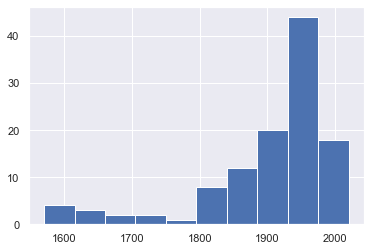

In [14]:
nbins = int(np.sqrt(len(df)))
df['year'].hist(bins=nbins)
plt.show()

In this plot, we see that the majority of events was registered in the 1900s. This is expected, as seismographs have become more widespread in the 20th century. Therefore, in the following, __we will only analyze events after the year 1900__. 

Notice that there is a decay on the number of events closer to the year 2000. Let us check the events in the past century more closely to see what is happening.

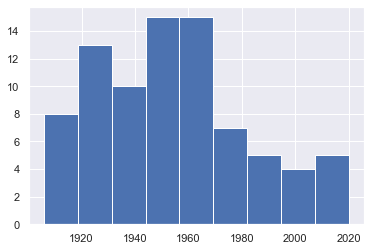

In [15]:
df1900 = df[df['year'] >= 1900]
nbins = int(np.sqrt(len(df1900)))
df1900['year'].hist(bins=nbins)
plt.show()

We see an important drop in the number of major events after 1970. It is unclear why that is the case and maybe we require a more refined analysis of earthquake phenomenology to understand what is going on. However, we know that a large number of rare random events folows a Poisson distribution. Would that be the case here? 

What is the average number of earthquakes per recorded year?

In [27]:
df1900['year'].value_counts().mean()

1.4385964912280702

We have a large number of apparently rare events, as there are less than 2 events per year and some years did not have large events. Therefore, we need to include the years that did _not_ have major events to make a proper analysis.

First, we create a table with all years from 1906 to 2020.

In [28]:
years = pd.DataFrame({'year' : range(min(df1900['year']), max(df1900['year'])+1)})
years.head()

,year
0,1906
1,1907
2,1908
3,1909
4,1910


Then we count the number of events per year and merge this table with the table with all the years.

In [100]:
event_count = df1900.value_counts('year').sort_index()
df_count = pd.DataFrame({'year': event_count.index, 'events' : event_count.values})
events_per_year = years.merge(df_count, on='year', how='left').replace(np.nan,0).astype(int).set_index('year')
events_per_year.head()

,events
year,
1906,1
1907,0
1908,0
1909,1
1910,1


In [32]:
avg_events_year = events_per_year.mean()[0]
avg_events_year

0.7130434782608696

We can now check the proportion of years between 1906 and 2020 that did not have major events:

In [33]:
(100*events_per_year[events_per_year.events == 0].count()/len(events_per_year))[0]

50.43478260869565

That is approximately 50%, suggesting that major events happen randomly across the years. Now let us check the observed distribution of the number of events. 

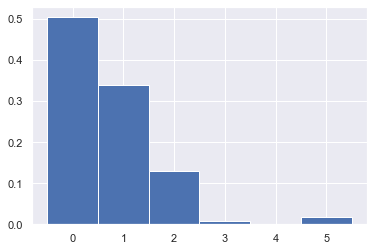

In [34]:
bins = np.arange(0, max(events_per_year.events) + 1.5) - 0.5
plt.hist(events_per_year, density=True, bins=bins)
plt.show()

We want to compare this with a Poisson distribution with an average of 0.71 events per year. 

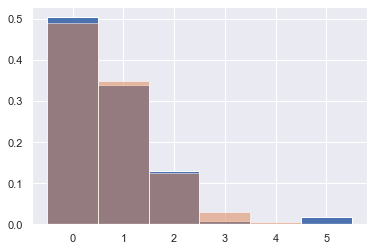

In [35]:
poisson = np.random.poisson(avg_events_year, 100000)

plt.hist(events_per_year, density=True, bins=bins)
plt.hist(poisson, density=True, bins=bins, alpha=0.5)

plt.show()

That looks very similar! We can see the match in more detail with an __empirical cumulative distribution function__ (ECDF), using the function defined below.

In [37]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

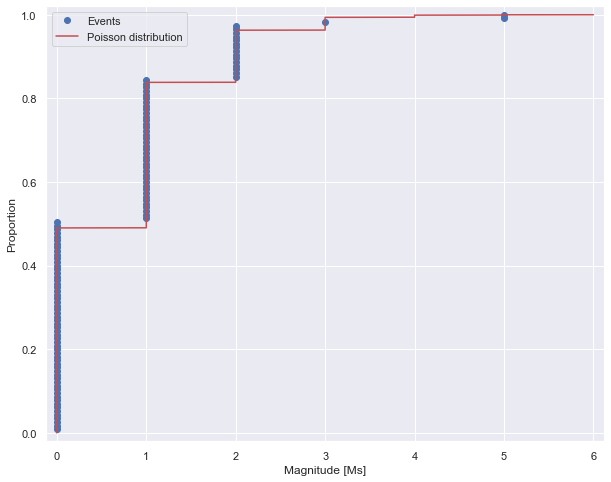

In [49]:
plt.figure(figsize=(10,8))

x, y = ecdf(events_per_year['events'])
xnb, ynb = ecdf(poisson)

plt.plot(x, y, 'bo', label='Events')
plt.plot(xnb, ynb, 'r-', label='Poisson distribution')
plt.xlabel('Magnitude [Ms]')
plt.ylabel('Proportion')

plt.legend()
plt.margins(0.02) # Keeps data off plot edges
plt.show()

The fit is quite good and the tiny mismatch must be due to the small number of recorded events.

Now let us check the distribution of events per month.

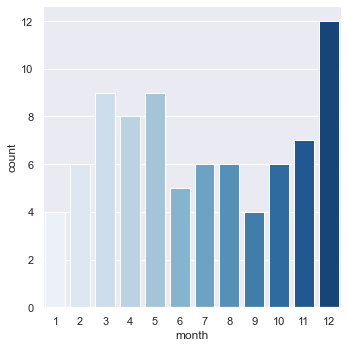

In [50]:
events_per_month = df1900.sort_values('month')
sns.catplot(x='month', data=events_per_month, kind='count', palette='Blues')
plt.show()

There is a larger amount of big earthquakes in December. How do we know if this is statistically significant? We can do a __hypothesis test__. Let us assume that earthquakes happen at random across the months of the year. What is the likelihood of getting the observed values? To test this, we shall create a large number of random __bootstrap samples__ from our month data and analyze the distribution of events.

Before doing that, let us check how close is the CDF of events to a uniformly random one.

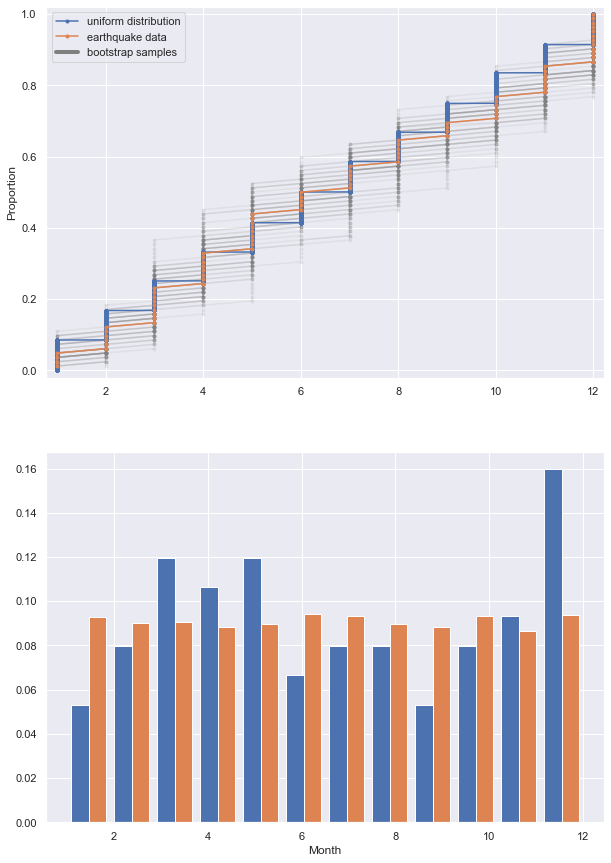

In [67]:
fig, ax = plt.subplots(nrows=2, figsize=(10,15))

for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(events_per_month.month.values, size=len(events_per_month.month.values))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = ax[0].plot(x, y, marker='.',
                 color='gray', alpha=0.1)

# Seed the random number generator
np.random.seed(42)

# Generate random numbers between 1 and 12 by looping over range(100000)
size = 10000 #len(events_per_month)
random_numbers = np.random.randint(1,13,size)

# Compute and plot ECDF from original data
x, y = ecdf(random_numbers)
line1, = ax[0].plot(x, y, marker='.', label='uniform distribution')

# Compute and plot ECDF from original data
x, y = ecdf(events_per_month.month)
line2, = ax[0].plot(x, y, marker='.', label='earthquake data')

ax[1].hist([events_per_month.month, random_numbers], density=True, bins=12)

# Make margins and label axes
ax[0].margins(0.02)
ax[0].set(ylabel='Proportion')
ax[1].set(xlabel='Month')

# Make legends
legend_elements = [line1, line2, Line2D([0], [0], color='grey', lw=4, label='bootstrap samples')]
ax[0].legend(handles=legend_elements, loc='upper left')


# Show the plot
plt.show()

That distributions look pretty similar, given the small number of earthquake events. We also plotted bootstrap samples in gray to see the variability of _randomly choosing the data with replacement_. The random distribution is within our level of variability. Now, we shall do our hypothesis testing to see _how close is the monthly event distribution_ to an uniform distribution.

#### Hypothesis testing

Our __null hypothesis__ here is that the _distribution of earthquakes per month is uniformly random_. To test this assumption, we shall use the _difference between the distributions' variance_ as our __test statistic__ and generate a large number of values from bootstrap samples. This will be accomplished by the following steps:

- Combine the empirical data with an uniformly distributed data of the same size.
- Permute the combined data with replacement and generate two new samples. This is a _bootstrap sample_.
- Repeat the process a large number of times and compute the test statistic for each sample. This is an _ensemble of bootstrap replicas_.
- Plot a histogram of the ensemble and compute the __p-value__ of our original test statistic.

If the p-value is small, the variance of the two distributions is statistically significantly different. Otherwise, we cannot discard the null hypothesis.

We start by defining some custom functions for our task.

In [68]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def diff_of_mean(data_1, data_2):
      """Difference in variance of two arrays."""
  
      # The difference of means of data_1, data_2: diff
      diff = np.mean(data_1) - np.mean(data_2)
  
      return diff

def diff_of_var(data_1, data_2):
      """Difference in variance of two arrays."""
  
      # The difference of means of data_1, data_2: diff
      diff = np.var(data_1) - np.var(data_2)
  
      return diff

We generate the uniform random distribution `random_numbers` and compute an ensemble of bootstrap replicates `bs_replicates` of size 10000.

In [69]:
bs_replicates = draw_perm_reps(events_per_month.month, random_numbers, diff_of_var, 10000)

Let us check the difference of the mean between the data and the random numbers

In [73]:
diff_of_mean(events_per_month.month, random_numbers)

0.29628292682926816

and the difference of variances is

In [74]:
diff_of_var(events_per_month.month, random_numbers)

0.6781642984890013

Now we can plot the distribution of the difference of variances in the ensemble and compare with the value above.

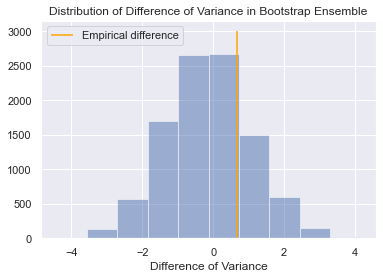

p-value = 0.2381


In [75]:
plt.hist(bs_replicates, alpha=0.5)
plt.vlines(x=diff_of_var(events_per_month.month.values, random_numbers),\
           ymin=0,ymax=3000, label='Empirical difference', color='orange')
plt.xlabel('Difference of Variance')
plt.title('Distribution of Difference of Variance in Bootstrap Ensemble')
plt.legend(loc='upper left')
plt.show()

# Computing the p-value
p = np.sum(bs_replicates >= diff_of_var(events_per_month.month.values, random_numbers)) / len(bs_replicates)
print('p-value =', p)

We see that the p-value is quite high, suggesting that we __cannot__ discard the null hypothesis, i.e., that the monthly distribution of earthquakes is approximately uniform.

### 3.2 Distributions of Earthquake Magnitudes in Time and Space

Let us compute the ECDF of the Ms magnitude.

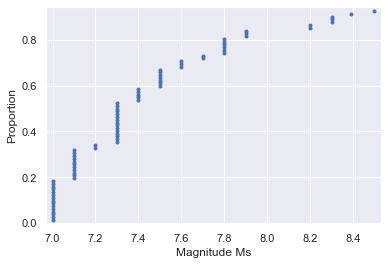

In [80]:
x, y = ecdf(df1900['mag_ms'])
plt.plot(x, y, '.')
plt.xlabel('Magnitude Ms')
plt.ylabel('Proportion')
plt.margins(0.02) # Keeps data off plot edges
plt.show()

From this we see that around 60% of major earthquakes had a magnitude Ms lower or equal than 7.4 and only 20% of the events had a magnitude higher than 7.8. We can see this in more detail with a histogram:

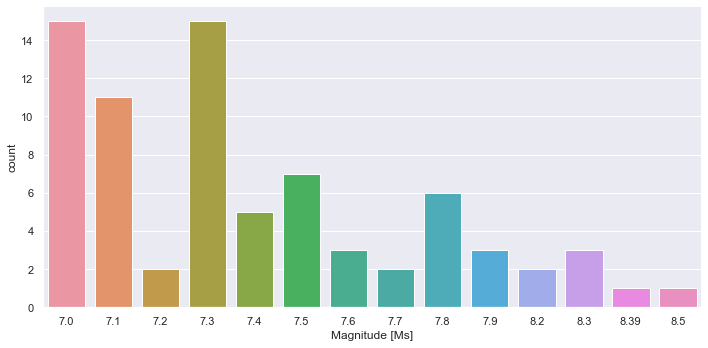

In [81]:
magnitud_ms = df1900[~df1900['mag_ms'].isna()].sort_values('mag_ms')

g1 = sns.catplot(x='mag_ms',data=magnitud_ms, kind='count', aspect=2)
g1.set(xlabel='Magnitude [Ms]')
plt.show()

We can also check the Magnitude distribution per month with a boxplot.

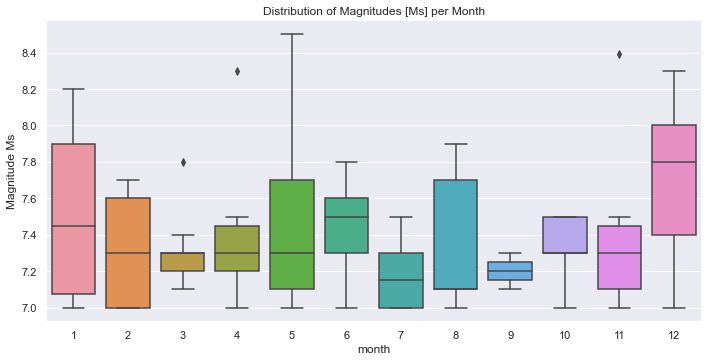

In [124]:
g = sns.catplot(x='month', y='mag_ms', data=magnitud_ms, kind='box', aspect=2)
g.set(ylabel='Magnitude Ms', title='Distribution of Magnitudes [Ms] per Month')
plt.show()

There is a large variability with respect to different months, but this is probably due to the small number of events.

Do we see any trend in the event's magnitudes in time? We can test this by a linear regression plot.

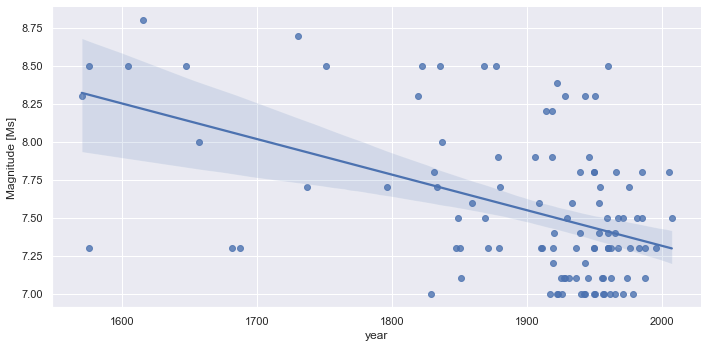

In [125]:
g1 = sns.lmplot(y='mag_ms', x='year', data=df, aspect=2)
g1.set(ylabel='Magnitude [Ms]')

plt.show()

There is a significant slope, but we included the events before 1900. This data is unreliable and very sparse, as can be seen above. If we restrict to events after 1900, the trend is much less prominent.

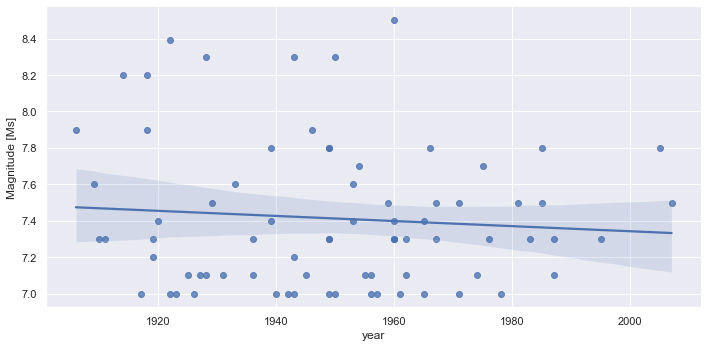

In [133]:
g1 = sns.lmplot(y='mag_ms', x='year', data=magnitud_ms, aspect=2)
g1.set(ylabel='Magnitude [Ms]')

plt.show()

Now we see only a slight decline in the average magnitude. Let us check the __Pearson correlation coefficient__ of magnitude and year.

In [128]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [129]:
pearson_r(magnitud_ms['year'].values,magnitud_ms['mag_ms'].values)

-0.0848799103150612

The values is small, suggesting there is no strong negative correlation between magnitude and year. 

We can also take a look at the spatial distribution of magnitudes with a simple scatter plot. 

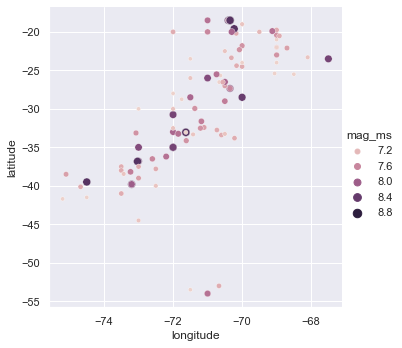

In [134]:
g2 = sns.relplot(x='longitude', y='latitude', data=df, kind='scatter', size='mag_ms', hue='mag_ms')

plt.show()

In order to look like the usual Mercator world map projection, we would need to rescale the axis and do an overlay with Chile's territory. It is easier to use the library `folium` to create a map with the distribution of major earthquakes in Chile. Let us generate an interactive map of all major events since 1950 that the magnitude Ms has been recorded.

In [135]:
events_locations = df[(df['year'] > 1950) & ~(df['mag_ms'].isna())][['latitude','longitude','mag_ms','year']]

map = folium.Map(location=[events_locations.latitude.mean(), events_locations.longitude.mean()],\
                 zoom_start=4, control_scale=True, tiles="Stamen Terrain")


for index, location_info in events_locations.iterrows():
    popup_text = 'Year: '+str(int(location_info['year'])) +'\nMagnitude Ms: '+str(location_info['mag_ms'])
    folium.Marker([location_info["latitude"], location_info["longitude"]],\
                 popup=popup_text).add_to(map)
    
map

Finally, just out of curiosity, let us see all the major events in 1960, the year of the biggest recorded earthquake in history, which nearly destroyed the city of Valdivia in the south of Chile.

In [60]:
df_clean[df_clean['year'] == 1960]

,date,time,latitude,longitude,mag_ms,mag_mw,depth_km,effect,year,month,day
80,21/05/1960,6:02,-37.5,-73.5,7.3,NaN,NaN,NaN,1960,5,21
81,22/05/1960,6:32,-37.5,-73.0,7.3,NaN,NaN,NaN,1960,5,22
82,22/05/1960,15:11,-39.5,-74.5,8.5,9.5,NaN,TD,1960,5,22
83,19/06/1960,22:01,-38.0,-73.5,7.3,NaN,NaN,NaN,1960,6,19
84,01/11/1960,4:45,-38.5,-75.1,7.4,NaN,55.0,NaN,1960,11,1


In the span of two days, there were 3 major events with magnitude Ms higher than 7.0! The major one had a magnitude of 8.5 and a historical reconstruction of the event estimates a magnitude Mw of 9.5, the highest ever in the recorded history.

## Next Steps

* Do a more detailed statistical analysis of the magnitude distributions.
* Check the Gutenber-Ritcher (Log(number of events per century) vs. magnitude) and Utsu-Omori laws (distribution of replicas with time).
* Can we find correlations between these events and other geophysical data like volcano eruptions?
* Explore other datasets with a larger quantity of events.
* Try to predict earthquakes from seismograph data.